# Applying fill-spill-merge over REMA
This is the first time I have applied fill-spill-merge on REMA. I an starting with a very small subset of REMA created using 'download_REMA_subsets_2.ipynb'.

In [17]:
import rasterio
from matplotlib import pyplot as plt
from urllib.request import urlretrieve
import numpy as np
import xarray as xr
import os
import rasterio
import rioxarray
import panel.widgets as pnw
import hvplot.xarray # noqa 
%matplotlib widget

`fsm_and_plots` is for running and plotting the results of fill-spill-merge. 

when you supply a uniform water input it seems to return fields that are not georeferenced. 

m Input DEM           = rema_subsets/dem_small_1.tif
m Output prefix       = fsm_results/rema_tests/test
m Surface water level = 10
m Surface water file  = 
m Ocean level         = 0
m Data width  = 4095
m Data height = 4095
m Data cells  = 16769025


Finished.
IO time   = 0.198493 s
Calc time = 4.52314 s


/Users/jkingslake/miniconda3/envs/full_py_env/lib/python3.11/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


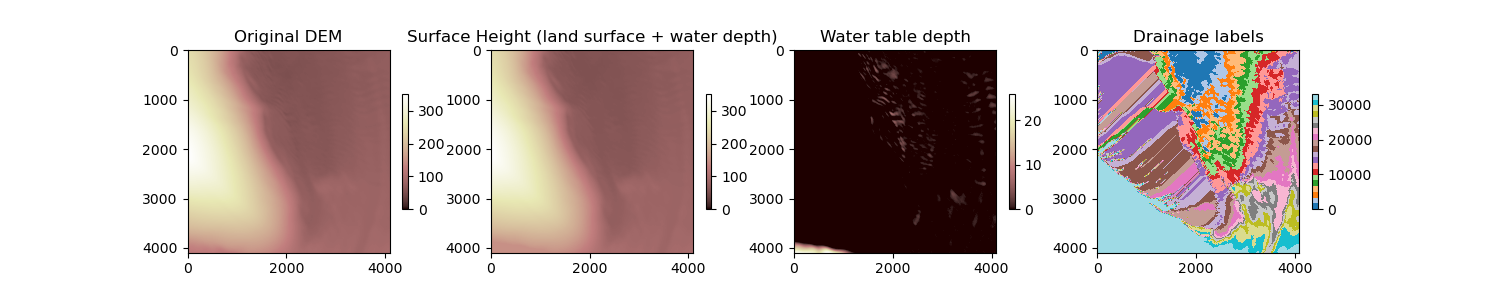

In [2]:
def replace_nodata_with_nan(array):
    array[array == -9990.0] = np.nan
    return array


def load_plot_tiff(f, fig, ax):
    
    # load
    with rasterio.open(f) as dataset:
        raster = dataset.read(1)
    raster = replace_nodata_with_nan(raster.astype(float))
    # plot
    im = ax.imshow(raster, cmap='pink', vmin=-0)
    fig.colorbar(im, ax=ax, shrink=0.5)
    
    return im

def fsm_and_plots(dem_filename, uniform_water_input=1):
    
    # setup figure
    fig, axs = plt.subplots(1,4, figsize=(15,3))

    # load and plot the DEM
    load_plot_tiff(dem_filename, fig, axs[0])
    axs[0].set_title('Original DEM')

    # run fsm
    sea_level = 0.0
    prefix = "fsm_results/rema_tests/test"
    os.system(f"../build/fsm.exe {dem_filename} {prefix} {sea_level} --swl={uniform_water_input}")

    # load and plot the water surface height
    load_plot_tiff(f'{prefix}-hydrologic-surface-height.tif', fig, axs[1])
    axs[1].set_title('Surface Height (land surface + water depth)')

    # load and plot the water surface height
    load_plot_tiff(f'{prefix}-wtd.tif', fig, axs[2])
    axs[2].set_title('Water table depth')

    # load and plot the water surface height
    im = load_plot_tiff(f'{prefix}-label.tif', fig, axs[3])
    axs[3].set_title('Drainage labels')
    im.set_cmap('tab20')


    plt.show()

    return 

fsm_and_plots("rema_subsets/dem_small_1.tif", uniform_water_input=10)

## A function just for fsm
Let's create a function that just does fill-spill-merge. I will need to deal with the case when use a uniform water input and when you use a filed of water input.

In [3]:
%%time
def fsm(dem_filename, 
        prefix = "fsm_results/rema_tests/test", 
        uniform_water_input=None, 
        water_input_file=None, 
        sea_level=0.0):
    
    print("running fill-spill-merge...")

    if uniform_water_input is not None:
        os.system(f"../build/fsm.exe {dem_filename} {prefix} {sea_level} --swl={uniform_water_input}")

    if water_input_file is not None:
        os.system(f"../build/fsm.exe {dem_filename} {prefix} {sea_level} --swf={water_input_file}")

    if uniform_water_input is None and water_input_file is None:
        raise ValueError("Must specify either uniform_water_input or water_input_file") 


    print("loading results...")
    #surface_height = rioxarray.open_rasterio(prefix + "surface-height.tif").squeeze()
    wtd = rioxarray.open_rasterio(prefix + "-wtd.tif").squeeze()
    #labels = rioxarray.open_rasterio(prefix + "label.tif").squeeze()

    return wtd
wtd = fsm("rema_subsets/dem_small_1.tif", uniform_water_input=1)   # again, this makes a tif without geograeferencing

wtd.plot()

running fill-spill-merge...
m Input DEM           = rema_subsets/dem_small_1.tif
m Output prefix       = fsm_results/rema_tests/test
m Surface water level = 1
m Surface water file  = 
m Ocean level         = 0
m Data width  = 4095
m Data height = 4095
m Data cells  = 16769025


Finished.
IO time   = 0.206742 s
Calc time = 5.11211 s
loading results...


/Users/jkingslake/miniconda3/envs/full_py_env/lib/python3.11/site-packages/rioxarray/_io.py:1132: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  warnings.warn(str(rio_warning.message), type(rio_warning.message))  # type: ignore


CPU times: user 524 ms, sys: 127 ms, total: 651 ms
Wall time: 6.06 s


Make a raster to define  a spatially verying water supply

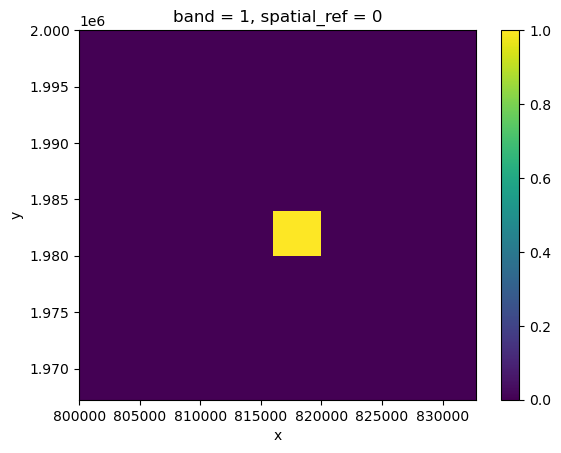

In [129]:
# create a water input file using the DEM
dem = rioxarray.open_rasterio("rema_subsets/dem_small_1.tif", chunks={})

def create_water_input_file(dem, water_depth):
    water=dem.squeeze()
    water[:,:]=0
    water[2000:2500, 2000:2500]=water_depth
    water_input_file = "rema_subsets/water_input_file.tif"
    water.rio.to_raster(water_input_file)

    return water, water_input_file

create_water_input_file(dem, 1)[0].plot()


running fill-spill-merge...
m Input DEM           = rema_subsets/dem_small_1.tif
m Output prefix       = fsm_results/rema_tests/test
m Surface water level = nan
m Surface water file  = rema_subsets/water_input_file.tif
m Ocean level         = 0
m Data width  = 4095
m Data height = 4095
m Data cells  = 16769025


Finished.
IO time   = 0.245815 s
Calc time = 3.97354 s
loading results...


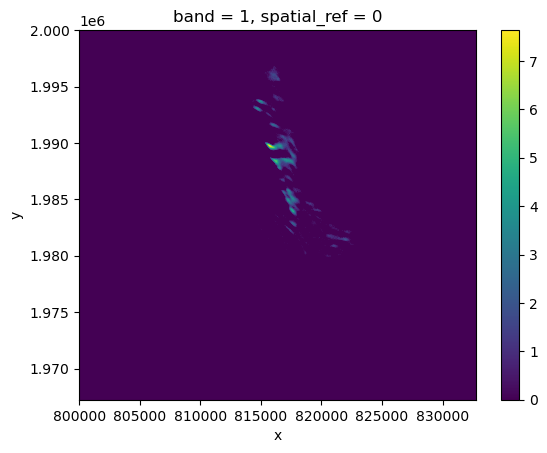

In [130]:
wtd1 = fsm("rema_subsets/dem_small_1.tif", water_input_file="rema_subsets/water_input_file.tif")
wtd1.plot()

running fill-spill-merge...
m Input DEM           = rema_subsets/dem_small_1.tif
m Output prefix       = fsm_results/rema_tests/test
m Surface water level = nan
m Surface water file  = rema_subsets/water_input_file.tif
m Ocean level         = 0
m Data width  = 4095
m Data height = 4095
m Data cells  = 16769025


Finished.
IO time   = 0.265336 s
Calc time = 3.88201 s
loading results...


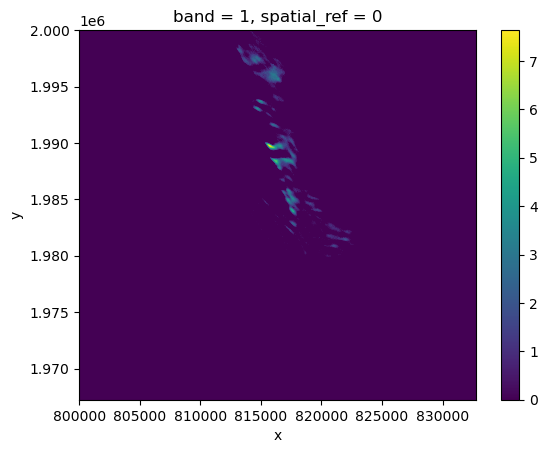

In [113]:
water, water_input_file =create_water_input_file(dem, 20)
wtd20 = fsm("rema_subsets/dem_small_1.tif", water_input_file=water_input_file)

wtd20.plot()

running fill-spill-merge...
m Input DEM           = rema_subsets/dem_small_1.tif
m Output prefix       = fsm_results/rema_tests/test
m Surface water level = nan
m Surface water file  = rema_subsets/water_input_file.tif
m Ocean level         = 0
m Data width  = 4095
m Data height = 4095
m Data cells  = 16769025


Finished.
IO time   = 0.263763 s
Calc time = 3.86444 s
loading results...


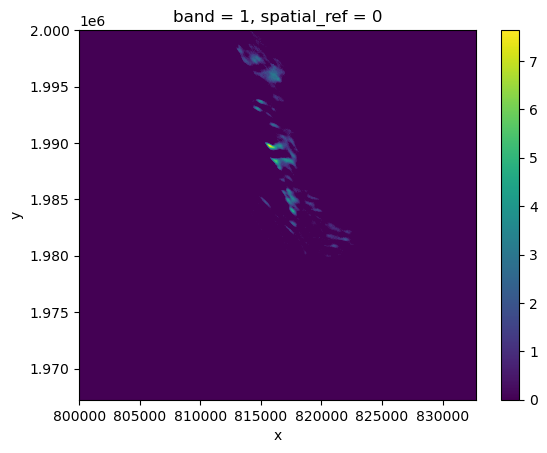

In [114]:
water, water_input_file = create_water_input_file(dem, 200)
wtd200 = fsm("rema_subsets/dem_small_1.tif", water_input_file=water_input_file)

wtd200.plot()

running fill-spill-merge...
m Input DEM           = rema_subsets/dem_small_1.tif
m Output prefix       = fsm_results/rema_tests/test
m Surface water level = nan
m Surface water file  = rema_subsets/water_input_file.tif
m Ocean level         = 0
m Data width  = 4095
m Data height = 4095
m Data cells  = 16769025


Finished.
IO time   = 0.32089 s
Calc time = 3.75976 s
loading results...


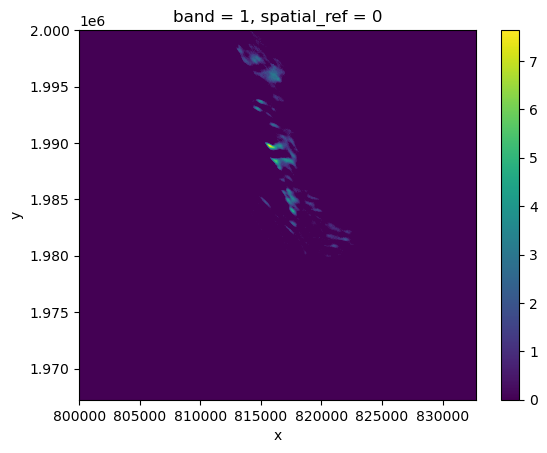

In [135]:
water, water_input_file = create_water_input_file(dem, 2000)
wtd2000 = fsm("rema_subsets/dem_small_1.tif", water_input_file=water_input_file)

wtd2000.plot()

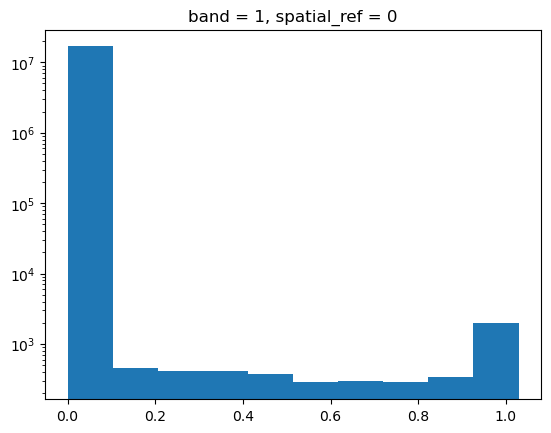

In [ ]:
(wtd2000-wtd20).plot.hist(log=True);

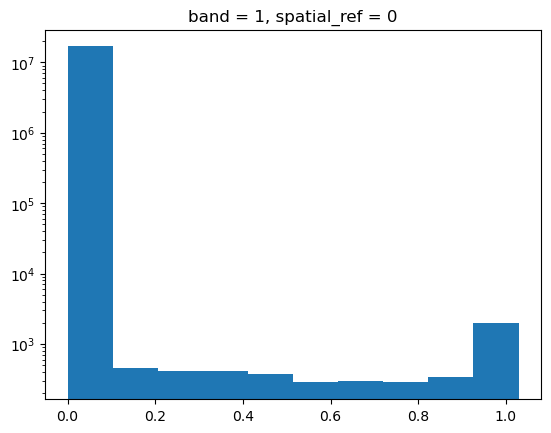

In [ ]:
(wtd200-wtd20).plot.hist(log=True);

In [4]:
dem_filename = "rema_subsets/dem_small_2.tif"
# create a water input file using the second REMA-subest DEM
dem = rioxarray.open_rasterio(dem_filename, chunks={})

def create_water_input_file(dem, water_depth, xmin=815000, xmax=820000, ymin=1.94e6, ymax=1.945e6):
    water=dem.squeeze()
    water[:,:]=0
    water.loc[ymax:ymin, xmin:xmax]=water_depth # ymin and ymax are flipped because the y-axis is flipped
    water_input_file = "rema_subsets/water_input_file_2.tif"
    water.rio.to_raster(water_input_file)
    bounds = (xmin, ymin, xmax, ymax)
    return water, water_input_file , bounds

#create_water_input_file(dem, 1)[0].plot()

water, water_input_file, bounds = create_water_input_file(dem, 20)
water.plot()
wtd_new_dem = fsm(dem_filename, water_input_file=water_input_file)


running fill-spill-merge...
m Input DEM           = rema_subsets/dem_small_2.tif
m Output prefix       = fsm_results/rema_tests/test
m Surface water level = nan
m Surface water file  = rema_subsets/water_input_file_2.tif
m Ocean level         = 0
m Data width  = 1024
m Data height = 3072
m Data cells  = 3145728


Finished.
IO time   = 0.0536958 s
Calc time = 2.52911 s
loading results...


running fill-spill-merge...
m Input DEM           = rema_subsets/dem_small_2.tif
m Output prefix       = fsm_results/rema_tests/test
m Surface water level = nan
m Surface water file  = rema_subsets/water_input_file_2.tif
m Ocean level         = 0
m Data width  = 1024
m Data height = 3072
m Data cells  = 3145728


Finished.
IO time   = 0.0543038 s
Calc time = 2.26447 s
loading results...


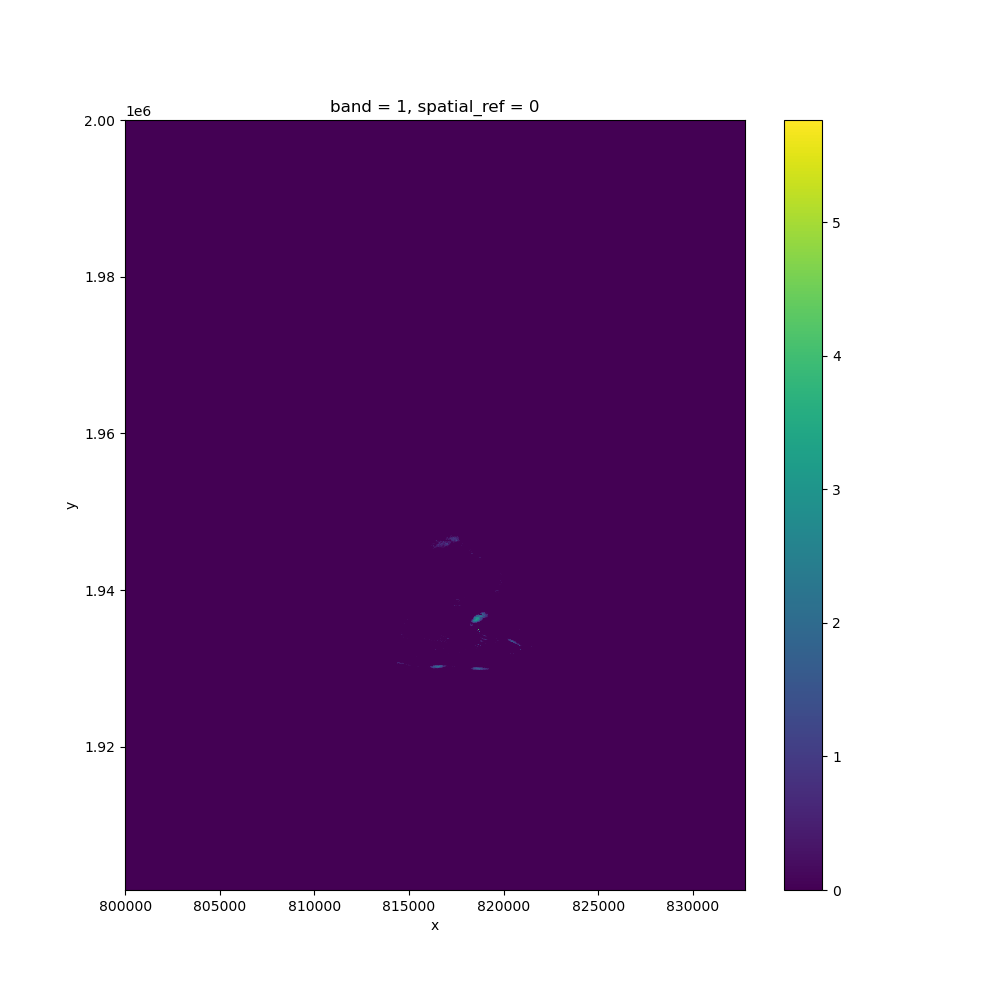

In [5]:
dem_filename = "rema_subsets/dem_small_2.tif"
# create a water input file using the second REMA-subest DEM
dem = rioxarray.open_rasterio(dem_filename, chunks={})

def create_water_input_file(dem, water_depth, xmin=815000, xmax=820000, ymin=1.94e6, ymax=1.945e6):
    water=dem.copy().squeeze()
    water[:,:]=0
    water.loc[ymax:ymin, xmin:xmax]=water_depth # ymin and ymax are flipped because the y-axis is flipped
    water_input_file = "rema_subsets/water_input_file_2.tif"
    water.rio.to_raster(water_input_file)
    bounds = (xmin, ymin, xmax, ymax)
    return water, water_input_file, bounds

#create_water_input_file(dem, 1)[0].plot()

water, water_input_file, bounds = create_water_input_file(dem, 0.1, xmin=815000, xmax=820000, ymin=1.93e6, ymax=1.935e6)
wtd_new_dem = fsm(dem_filename, water_input_file=water_input_file)

plot = wtd_new_dem.plot(figsize=(10,10))
# plot a square around the area where the water was added (this is the old way of doing it)
#x0, y0, x1, y1 = bounds
#rect = plt.Rectangle((x0, y0), x1-x0, y1-y0, fill=None, color='red')
#plot.axes.add_patch(rect)


Loop over a list of different water supplies and run fsm on each one, saving the result in a list and then concatenating into an xarray along with the DEM and the water supplies. 

In [225]:
wtds = []
waters = []
dem_filename = "rema_subsets/dem_small_2.tif"
# create a water input file using the second REMA-subest DEM
dem = rioxarray.open_rasterio(dem_filename, chunks={})
dem = dem.squeeze()
inputs = np.linspace(start=1, stop=17, num=30)
print(f"running fsm for inputs: {inputs} m ...")

for input in inputs:
    water, water_input_file, bounds = create_water_input_file(dem, input, xmin=815000, xmax=820000, ymin=1.93e6, ymax=1.935e6)
    
    waters.append(water)
    wtds.append(fsm(dem_filename, water_input_file=water_input_file))



inputs_xr = xr.DataArray(inputs, dims='inputs', name='inputs') # i created a new xarray from the list 'input' so that I could pass both the values or input and the name 'input' to concat below
wtd = xr.concat(wtds, dim=inputs_xr)
water = xr.concat(waters, dim=inputs_xr)
wtd.name = 'wtd'
dem.name = 'dem'
water.name = 'water'


results = xr.merge([wtd, dem, water])
results = results.drop_vars('band')

# add the center of mass of the water (see centroid_test.ipynb for notes on ths method)
results['x_center'] = results.x.weighted(results.wtd).mean(dim = ['x', 'y'])
results['y_center'] = results.y.weighted(results.wtd).mean(dim = ['x', 'y'])




running fsm for inputs: [ 1.          1.55172414  2.10344828  2.65517241  3.20689655  3.75862069
  4.31034483  4.86206897  5.4137931   5.96551724  6.51724138  7.06896552
  7.62068966  8.17241379  8.72413793  9.27586207  9.82758621 10.37931034
 10.93103448 11.48275862 12.03448276 12.5862069  13.13793103 13.68965517
 14.24137931 14.79310345 15.34482759 15.89655172 16.44827586 17.        ] m ...
running fill-spill-merge...
m Input DEM           = rema_subsets/dem_small_2.tif
m Output prefix       = fsm_results/rema_tests/test
m Surface water level = nan
m Surface water file  = rema_subsets/water_input_file_2.tif
m Ocean level         = 0
m Data width  = 1024
m Data height = 3072
m Data cells  = 3145728


Finished.
IO time   = 0.0660636 s
Calc time = 2.21024 s
loading results...
running fill-spill-merge...
m Input DEM           = rema_subsets/dem_small_2.tif
m Output prefix       = fsm_results/rema_tests/test
m Surface water level = nan
m Surface water file  = rema_subsets/water_input_file_2.tif
m Ocean level         = 0
m Data width  = 1024
m Data height = 3072
m Data cells  = 3145728


Finished.
IO time   = 0.0725912 s
Calc time = 2.60356 s
loading results...
running fill-spill-merge...
m Input DEM           = rema_subsets/dem_small_2.tif
m Output prefix       = fsm_results/rema_tests/test
m Surface water level = nan
m Surface water file  = rema_subsets/water_input_file_2.tif
m Ocean level         = 0
m Data width  = 1024
m Data height = 3072
m Data cells  = 3145728


Finished.
IO time   = 0.0512219 s
Calc time = 2.42739 s
loading results...
running fill-spill-merge...
m Input DEM           = rema_subsets/dem_small_2.tif
m Output prefix       = fsm_results/rema_tests/test
m Surface water level = nan
m Surface water file  = rema_subsets/water_input_file_2.tif
m Ocean level         = 0
m Data width  = 1024
m Data height = 3072
m Data cells  = 3145728


Finished.
IO time   = 0.0606076 s
Calc time = 2.4819 s
loading results...
running fill-spill-merge...
m Input DEM           = rema_subsets/dem_small_2.tif
m Output prefix       = fsm_results/rema_tests/test
m Surface water level = nan
m Surface water file  = rema_subsets/water_input_file_2.tif
m Ocean level         = 0
m Data width  = 1024
m Data height = 3072
m Data cells  = 3145728


Finished.
IO time   = 0.0769406 s
Calc time = 2.47111 s
loading results...
running fill-spill-merge...
m Input DEM           = rema_subsets/dem_small_2.tif
m Output prefix       = fsm_results/rema_tests/test
m Surface water level = nan
m Surface water file  = rema_subsets/water_input_file_2.tif
m Ocean level         = 0
m Data width  = 1024
m Data height = 3072
m Data cells  = 3145728


Finished.
IO time   = 0.0546328 s
Calc time = 2.3779 s
loading results...
running fill-spill-merge...
m Input DEM           = rema_subsets/dem_small_2.tif
m Output prefix       = fsm_results/rema_tests/test
m Surface water level = nan
m Surface water file  = rema_subsets/water_input_file_2.tif
m Ocean level         = 0
m Data width  = 1024
m Data height = 3072
m Data cells  = 3145728


Finished.
IO time   = 0.0495914 s
Calc time = 2.32212 s
loading results...
running fill-spill-merge...
m Input DEM           = rema_subsets/dem_small_2.tif
m Output prefix       = fsm_results/rema_tests/test
m Surface water level = nan
m Surface water file  = rema_subsets/water_input_file_2.tif
m Ocean level         = 0
m Data width  = 1024
m Data height = 3072
m Data cells  = 3145728


Finished.
IO time   = 0.0451061 s
Calc time = 2.15427 s
loading results...
running fill-spill-merge...
m Input DEM           = rema_subsets/dem_small_2.tif
m Output prefix       = fsm_results/rema_tests/test
m Surface water level = nan
m Surface water file  = rema_subsets/water_input_file_2.tif
m Ocean level         = 0
m Data width  = 1024
m Data height = 3072
m Data cells  = 3145728


Finished.
IO time   = 0.0501599 s
Calc time = 2.2766 s
loading results...
running fill-spill-merge...
m Input DEM           = rema_subsets/dem_small_2.tif
m Output prefix       = fsm_results/rema_tests/test
m Surface water level = nan
m Surface water file  = rema_subsets/water_input_file_2.tif
m Ocean level         = 0
m Data width  = 1024
m Data height = 3072
m Data cells  = 3145728


Finished.
IO time   = 0.0499872 s
Calc time = 2.37488 s
loading results...
running fill-spill-merge...
m Input DEM           = rema_subsets/dem_small_2.tif
m Output prefix       = fsm_results/rema_tests/test
m Surface water level = nan
m Surface water file  = rema_subsets/water_input_file_2.tif
m Ocean level         = 0
m Data width  = 1024
m Data height = 3072
m Data cells  = 3145728


Finished.
IO time   = 0.0520201 s
Calc time = 2.47151 s
loading results...
running fill-spill-merge...
m Input DEM           = rema_subsets/dem_small_2.tif
m Output prefix       = fsm_results/rema_tests/test
m Surface water level = nan
m Surface water file  = rema_subsets/water_input_file_2.tif
m Ocean level         = 0
m Data width  = 1024
m Data height = 3072
m Data cells  = 3145728


Finished.
IO time   = 0.0539682 s
Calc time = 2.46437 s
loading results...
running fill-spill-merge...
m Input DEM           = rema_subsets/dem_small_2.tif
m Output prefix       = fsm_results/rema_tests/test
m Surface water level = nan
m Surface water file  = rema_subsets/water_input_file_2.tif
m Ocean level         = 0
m Data width  = 1024
m Data height = 3072
m Data cells  = 3145728


Finished.
IO time   = 0.0504055 s
Calc time = 2.35162 s
loading results...
running fill-spill-merge...
m Input DEM           = rema_subsets/dem_small_2.tif
m Output prefix       = fsm_results/rema_tests/test
m Surface water level = nan
m Surface water file  = rema_subsets/water_input_file_2.tif
m Ocean level         = 0
m Data width  = 1024
m Data height = 3072
m Data cells  = 3145728


Finished.
IO time   = 0.0466456 s
Calc time = 2.17765 s
loading results...
running fill-spill-merge...
m Input DEM           = rema_subsets/dem_small_2.tif
m Output prefix       = fsm_results/rema_tests/test
m Surface water level = nan
m Surface water file  = rema_subsets/water_input_file_2.tif
m Ocean level         = 0
m Data width  = 1024
m Data height = 3072
m Data cells  = 3145728


Finished.
IO time   = 0.0545457 s
Calc time = 2.22016 s
loading results...
running fill-spill-merge...
m Input DEM           = rema_subsets/dem_small_2.tif
m Output prefix       = fsm_results/rema_tests/test
m Surface water level = nan
m Surface water file  = rema_subsets/water_input_file_2.tif
m Ocean level         = 0
m Data width  = 1024
m Data height = 3072
m Data cells  = 3145728


Finished.
IO time   = 0.044506 s
Calc time = 2.24855 s
loading results...
running fill-spill-merge...
m Input DEM           = rema_subsets/dem_small_2.tif
m Output prefix       = fsm_results/rema_tests/test
m Surface water level = nan
m Surface water file  = rema_subsets/water_input_file_2.tif
m Ocean level         = 0
m Data width  = 1024
m Data height = 3072
m Data cells  = 3145728


Finished.
IO time   = 0.0458121 s
Calc time = 2.16502 s
loading results...
running fill-spill-merge...
m Input DEM           = rema_subsets/dem_small_2.tif
m Output prefix       = fsm_results/rema_tests/test
m Surface water level = nan
m Surface water file  = rema_subsets/water_input_file_2.tif
m Ocean level         = 0
m Data width  = 1024
m Data height = 3072
m Data cells  = 3145728


Finished.
IO time   = 0.0486113 s
Calc time = 2.22908 s
loading results...
running fill-spill-merge...
m Input DEM           = rema_subsets/dem_small_2.tif
m Output prefix       = fsm_results/rema_tests/test
m Surface water level = nan
m Surface water file  = rema_subsets/water_input_file_2.tif
m Ocean level         = 0
m Data width  = 1024
m Data height = 3072
m Data cells  = 3145728


Finished.
IO time   = 0.0559606 s
Calc time = 2.16298 s
loading results...
running fill-spill-merge...
m Input DEM           = rema_subsets/dem_small_2.tif
m Output prefix       = fsm_results/rema_tests/test
m Surface water level = nan
m Surface water file  = rema_subsets/water_input_file_2.tif
m Ocean level         = 0
m Data width  = 1024
m Data height = 3072
m Data cells  = 3145728


Finished.
IO time   = 0.0659614 s
Calc time = 2.40967 s
loading results...
running fill-spill-merge...
m Input DEM           = rema_subsets/dem_small_2.tif
m Output prefix       = fsm_results/rema_tests/test
m Surface water level = nan
m Surface water file  = rema_subsets/water_input_file_2.tif
m Ocean level         = 0
m Data width  = 1024
m Data height = 3072
m Data cells  = 3145728


Finished.
IO time   = 0.0524284 s
Calc time = 2.438 s
loading results...
running fill-spill-merge...
m Input DEM           = rema_subsets/dem_small_2.tif
m Output prefix       = fsm_results/rema_tests/test
m Surface water level = nan
m Surface water file  = rema_subsets/water_input_file_2.tif
m Ocean level         = 0
m Data width  = 1024
m Data height = 3072
m Data cells  = 3145728


Finished.
IO time   = 0.0620615 s
Calc time = 2.42038 s
loading results...
running fill-spill-merge...
m Input DEM           = rema_subsets/dem_small_2.tif
m Output prefix       = fsm_results/rema_tests/test
m Surface water level = nan
m Surface water file  = rema_subsets/water_input_file_2.tif
m Ocean level         = 0
m Data width  = 1024
m Data height = 3072
m Data cells  = 3145728


Finished.
IO time   = 0.0510385 s
Calc time = 2.45623 s
loading results...
running fill-spill-merge...
m Input DEM           = rema_subsets/dem_small_2.tif
m Output prefix       = fsm_results/rema_tests/test
m Surface water level = nan
m Surface water file  = rema_subsets/water_input_file_2.tif
m Ocean level         = 0
m Data width  = 1024
m Data height = 3072
m Data cells  = 3145728


Finished.
IO time   = 0.0518952 s
Calc time = 2.21126 s
loading results...
running fill-spill-merge...
m Input DEM           = rema_subsets/dem_small_2.tif
m Output prefix       = fsm_results/rema_tests/test
m Surface water level = nan
m Surface water file  = rema_subsets/water_input_file_2.tif
m Ocean level         = 0
m Data width  = 1024
m Data height = 3072
m Data cells  = 3145728


Finished.
IO time   = 0.0528583 s
Calc time = 2.22033 s
loading results...
running fill-spill-merge...
m Input DEM           = rema_subsets/dem_small_2.tif
m Output prefix       = fsm_results/rema_tests/test
m Surface water level = nan
m Surface water file  = rema_subsets/water_input_file_2.tif
m Ocean level         = 0
m Data width  = 1024
m Data height = 3072
m Data cells  = 3145728


Finished.
IO time   = 0.0455928 s
Calc time = 2.29229 s
loading results...
running fill-spill-merge...
m Input DEM           = rema_subsets/dem_small_2.tif
m Output prefix       = fsm_results/rema_tests/test
m Surface water level = nan
m Surface water file  = rema_subsets/water_input_file_2.tif
m Ocean level         = 0
m Data width  = 1024
m Data height = 3072
m Data cells  = 3145728


Finished.
IO time   = 0.0486382 s
Calc time = 2.3011 s
loading results...
running fill-spill-merge...
m Input DEM           = rema_subsets/dem_small_2.tif
m Output prefix       = fsm_results/rema_tests/test
m Surface water level = nan
m Surface water file  = rema_subsets/water_input_file_2.tif
m Ocean level         = 0
m Data width  = 1024
m Data height = 3072
m Data cells  = 3145728


Finished.
IO time   = 0.051674 s
Calc time = 2.26739 s
loading results...
running fill-spill-merge...
m Input DEM           = rema_subsets/dem_small_2.tif
m Output prefix       = fsm_results/rema_tests/test
m Surface water level = nan
m Surface water file  = rema_subsets/water_input_file_2.tif
m Ocean level         = 0
m Data width  = 1024
m Data height = 3072
m Data cells  = 3145728


Finished.
IO time   = 0.0501818 s
Calc time = 2.28664 s
loading results...
running fill-spill-merge...
m Input DEM           = rema_subsets/dem_small_2.tif
m Output prefix       = fsm_results/rema_tests/test
m Surface water level = nan
m Surface water file  = rema_subsets/water_input_file_2.tif
m Ocean level         = 0
m Data width  = 1024
m Data height = 3072
m Data cells  = 3145728


Finished.
IO time   = 0.049676 s
Calc time = 2.27942 s
loading results...


### Experiment with plotting methods


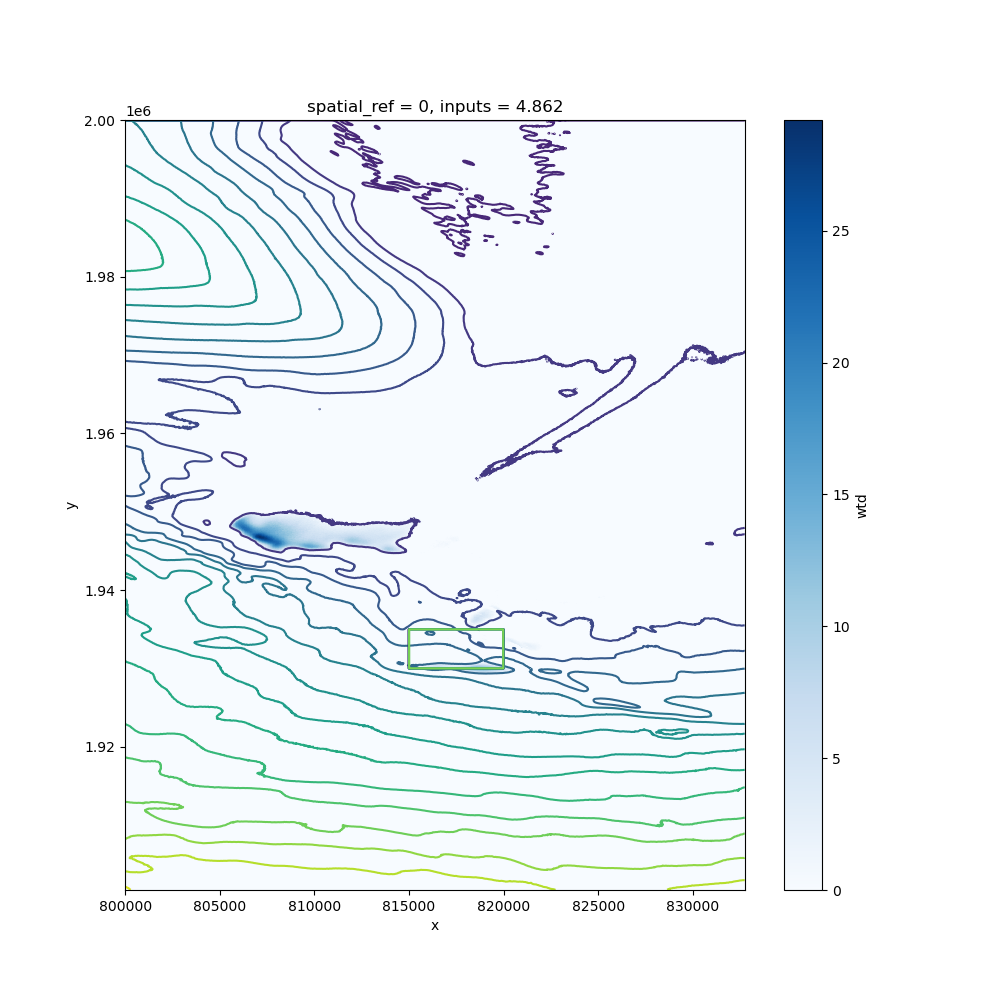

In [226]:
fig, axs = plt.subplots(ncols=1, nrows=1, figsize=(10, 10))

# plot the water table depth
results.wtd.isel(inputs = 19).plot(ax = axs, cmap='Blues')

# contour plot of dem
results.dem.plot.contour(ax = axs, levels=20)

# plot the box where the water was added
results.water.isel(inputs = 7).plot.contour(ax = axs)


In [227]:
coarse = results.coarsen(x=10, y=10, boundary='trim').mean()
coarse.wtd.hvplot(x ='y', y = 'x', cmap='Blues', clim=(0,1), width = 900, height = 300, aspect='equal')\
    * coarse.dem.hvplot.contour(x ='y', y = 'x',levels = 40, cmap='hot')\
    * coarse.water.hvplot.contour(x ='y', y = 'x', levels=[0.0, 0.0])\
    * coarse.hvplot.scatter(x = 'y_center', y = 'x_center', color = 'green', size = 400, marker = '*')

BokehModel(combine_events=True, render_bundle={'docs_json': {'360108c3-a1e5-4699-988d-b6605a57a980': {'version…

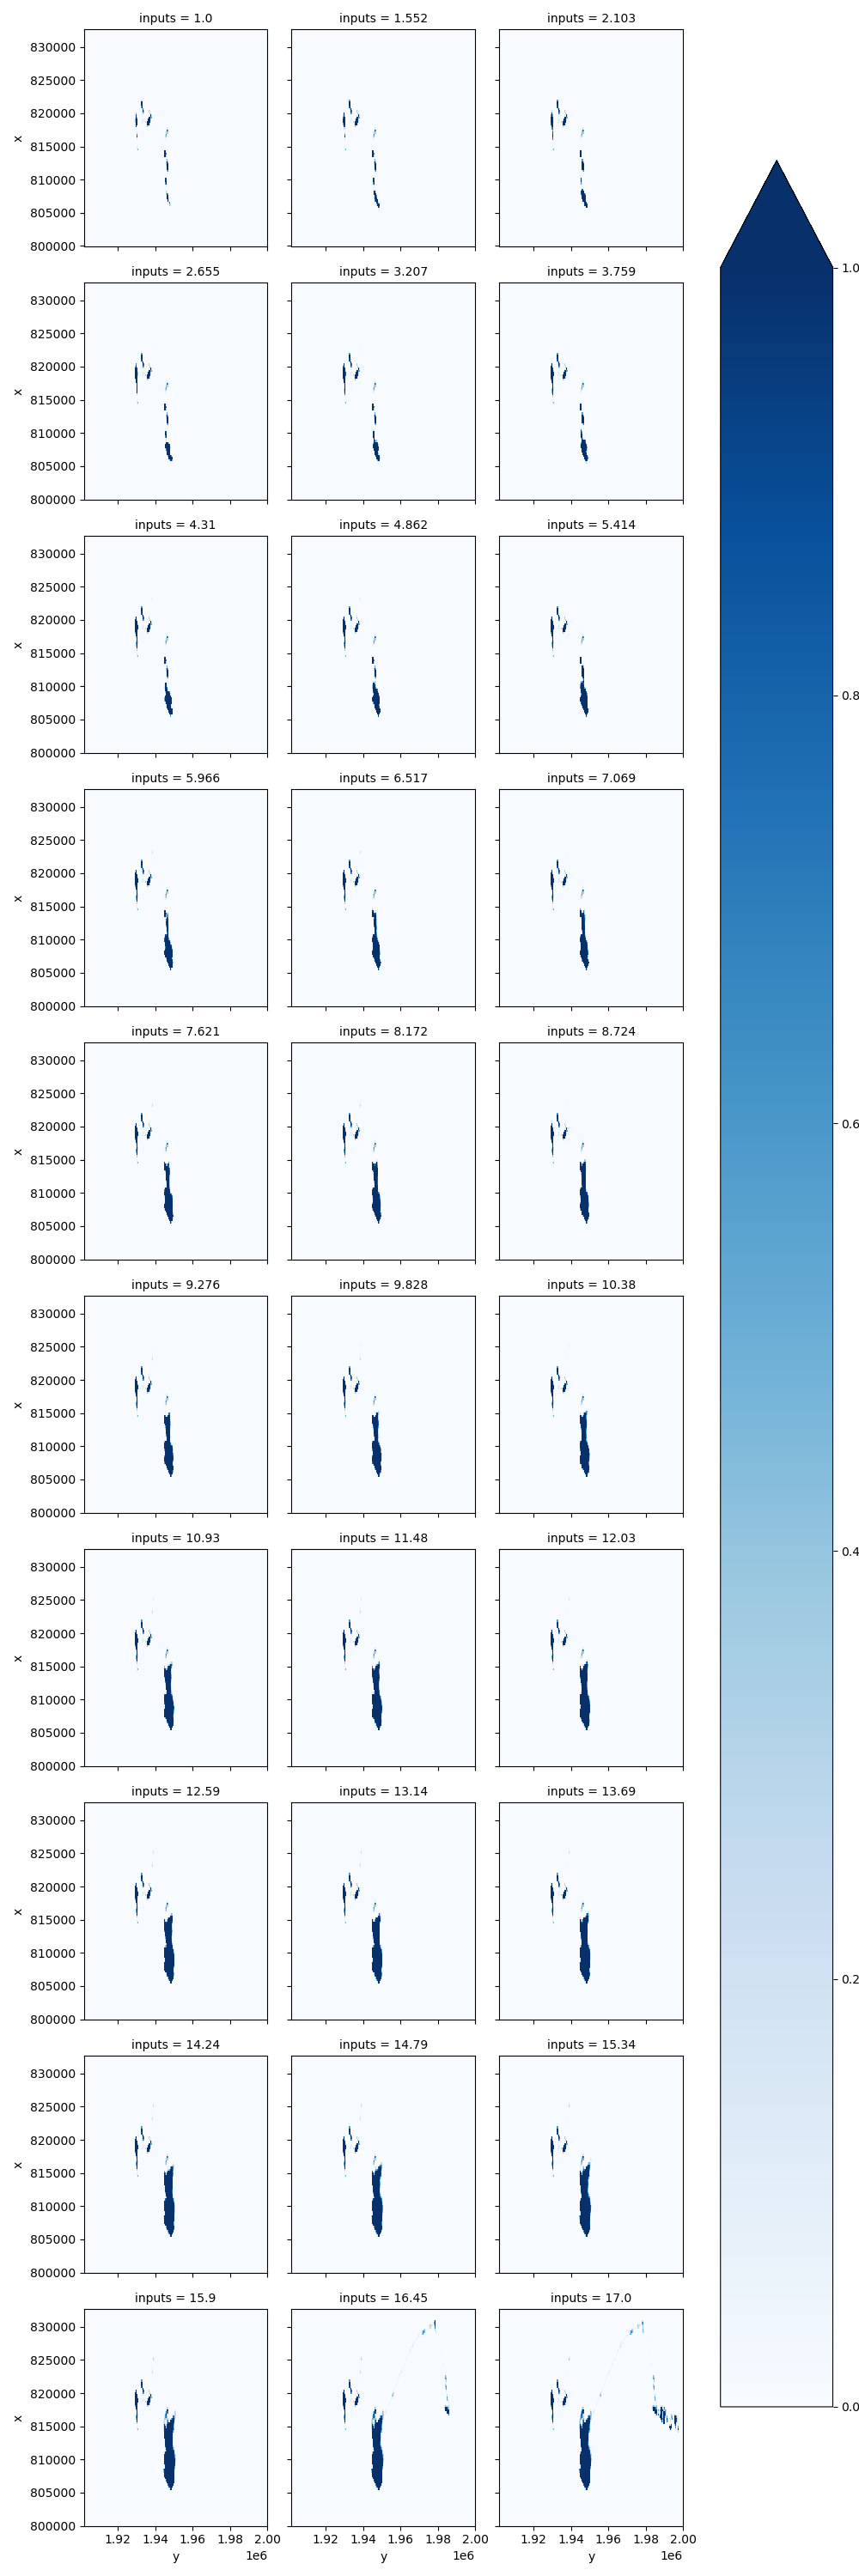

In [228]:
coarse.wtd.plot(x='y', y='x', col='inputs', col_wrap=3, cmap='Blues', vmin=0, vmax=1)
#plt.subplots_adjust(hspace=-1.2, wspace=-1.2)